<font color='blue'> **38-gwt-mt3dms-p02** </font> 
<font color='red'> **_______________________________  _______________________________** </font> 

In [1]:
import os ; import pathlib as pl ; from pprint import pformat ; import flopy ; import git ; import matplotlib.pyplot as plt
import numpy as np; from flopy.plot.styles import styles ; import pathlib; from pathlib import Path; import pandas as pd
import modflow_devtools.misc ; from modflow_devtools.misc import get_env, timed ; import flopy.utils.binaryfile as bf   # pip install modflow_devtools
from flopy.utils import Mf6ListBudget ; import csv
write = get_env("WRITE", True) ; run = get_env("RUN", True) ;  plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True) ; plot_save = get_env("PLOT_SAVE", True)

In [2]:
parameters = {"p02n2": {"sorption": "freundlich","Kf": 0.3,"a": 0.7,}  , "p02n2nn": {"sorption": "langmuir","Kl": 100.0,"S": 0.003,},      
              "p02c": {"beta": 0.0,}      , "p02d": {"beta": 0.002,}  , "p02e": {"beta": 0.01,}        , "p02f": {"beta": 20.0,},}
parameter_units={"beta":"$s^{-1}$","sorption":"text string","Kf": r"$\mu g L g^{} mg^{-1}$","a":"unitless","Kl": "$L mg^{-1}$","S": r"$\mu g g^{-1}$"}  
exe_name_mu = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6'
length_units = "centimeters" ; time_units = "seconds"               ; current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\51_MT3D_Zjeng_


In [3]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\51_MT3D_Zjeng_')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'ex-RES'    ; workspace = os.path.join('.', directory_name)
if os.path.isdir(workspace) is False:
    os.mkdir(workspace) 
output_folder = Path('ex-RES\\p02n2') ; output_folder.mkdir(exist_ok=True)
output_folder2 = Path('ex-RES\\p02n2\\mf6gwf') ; output_folder.mkdir(exist_ok=True)
output_folder3 = Path('ex-RES\\p02n2\\mf6gwt') ; output_folder.mkdir(exist_ok=True)

In [4]:
nlay = 1; nrow = 1; ncol = 101       ; nper = 2 ; period1 = 160  ; period2 = 1340  ; perlen = [period1, period2]   ; delta_time = 1.0 
delr = 0.16;delc = 0.16;top = 1.0    ; botm = 0 ; velocity = 0.1 ; hydraulic_conductivity = 0.01 ; porosity = 0.37 ; bulk_density = 1.587
distribution_coefficient = 0.933     ; dispersivity = 1.0        ; source_concentration = 0.05   ; initial_concentration = 0.0 

In [5]:
specific_discharge = velocity * porosity                            ; nstp = [6, 40]  ; tsmult = [1.1, 1.1]
inflow_rate        = specific_discharge * delc * (top - botm)      
system_length      = ncol * delr          
wel_spd            = {0: [[(0, 0, 0), inflow_rate, source_concentration],],1: [[(0, 0, 0), inflow_rate, 0.0],],}

specific_discharge, inflow_rate,  system_length

(0.037, 0.00592, 16.16)

In [6]:
perlen=[(1),(1),(1340)] ; nstp=[1,6,40,1] ; tsmult=[1, 1.2, 1.2] ; tdis_ds=list(zip(perlen, nstp, tsmult)) ; tdis_ds[-2:]   # tdis_ds[:2]

[(1, 6, 1.2), (1340, 40, 1.2)]

In [7]:
def build_mf6gwf(sim_folder):
    name    = "flow"
    sim_ws  = os.path.join(workspace, sim_folder, "mf6gwf")
    sim     = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
#    tdis_ds = [(1, 20, 1.2), (1340, 40, 1.2)] ;  nper = 2
    tdis_ds = ((period1, int(period1 / delta_time), 1.0),(period2, int(period2 / delta_time), 1.0))
    flopy.mf6.ModflowTdis         (sim, nper=nper , perioddata = tdis_ds , time_units=time_units)                    
    flopy.mf6.ModflowIms          (sim, print_option="summary", outer_dvclose=1.0e-8, inner_dvclose=1.0e-8)
    gwf = flopy.mf6.ModflowGwf    (sim, modelname=name, save_flows=True)  # hobj = gwf.output.head()      ; hds= hobj.get_data()
    dis = flopy.mf6.ModflowGwfdis (gwf,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)    
    flopy.mf6.ModflowGwfnpf       (gwf,save_specific_discharge=True,save_saturation=True,icelltype=0,k=hydraulic_conductivity)
    flopy.mf6.ModflowGwfic        (gwf, strt=1.0)
    flopy.mf6.ModflowGwfchd       (gwf, stress_period_data=[[(0, 0, ncol - 1), 1.0]])
    flopy.mf6.ModflowGwfwel       (gwf,stress_period_data=wel_spd,pname="WEL-1",auxiliary=["CONCENTRATION"],)
    head_filerecord = f"{name}.hds"
    budget_filerecord = f"{name}.bud"
    flopy.mf6.ModflowGwfoc  (gwf,head_filerecord = head_filerecord,
                             budget_filerecord   = budget_filerecord,
                             saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])
    return sim

def build_mf6gwt(sim_folder, sorption=None, Kf=None, a=None, Kl=None, S=None, beta=None):
    name    = "trans"
    sim_ws  = os.path.join(workspace, sim_folder, "mf6gwt")
    sim     = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
#    tdis_ds = [(1, 20, 1.2), (1340, 40, 1.2)] ;  nper = 2
    tdis_ds = ((period1, int(period1 / delta_time), 1.0),(period2, int(period2 / delta_time), 1.0))
    flopy.mf6.ModflowTdis(sim, nper=nper        , perioddata=tdis_ds   , time_units = time_units)                                
    flopy.mf6.ModflowIms(sim,linear_acceleration="bicgstab",print_option="summary" , outer_dvclose = 1.0e-8 , inner_dvclose=1.0e-8)
    gwt = flopy.mf6.ModflowGwt(sim, modelname=name, save_flows=True)
    flopy.mf6.ModflowGwtdis(gwt,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
    flopy.mf6.ModflowGwtic(gwt, strt=initial_concentration)

    distcoef = None
    if Kf is not None:
        distcoef = Kf
    if Kl is not None:
        distcoef = Kl
    sp2 = None
    if a is not None:
        sp2 = a
    if S is not None:
        sp2 = S
    volfracim = 0.0
    if beta is not None:
        if beta > 0:
            volfracim = bulk_density / (bulk_density + porosity)

    flopy.mf6.ModflowGwtmst(gwt,porosity=porosity / (1.0 - volfracim),
                            bulk_density=bulk_density if sorption else None,sorption=sorption,distcoef=distcoef,sp2=sp2)
    flopy.mf6.ModflowGwtadv(gwt, scheme="UPSTREAM")
    flopy.mf6.ModflowGwtdsp(gwt, xt3d_off=True, alh=dispersivity, ath1=dispersivity)
    
    if beta is not None:
        if beta > 0:
            porosity_im = bulk_density / volfracim          ; flopy.mf6.ModflowGwtist(gwt, volfrac=volfracim, porosity=porosity_im, zetaim=beta)
    pd = [ ("GWFHEAD", "../mf6gwf/flow.hds", None),("GWFBUDGET", "../mf6gwf/flow.bud", None)]
    
    flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)            ; sourcerecarray = [["WEL-1", "AUX", "CONCENTRATION"]]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray)    ; obs_data = {f"{name}.obs.csv": [("X008", "CONCENTRATION", (0, 0, 50)),],}  # !!!!
    obs_package = flopy.mf6.ModflowUtlobs(gwt, digits=10    , print_input=True, continuous=obs_data)
    flopy.mf6.ModflowGwtoc(gwt,
                           budget_filerecord=f"{name}.cbc",
                           concentration_filerecord=f"{name}.ucn",
                           saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")],printrecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")])
    return sim
    
def build_models(sim_name, **kwargs):
    sim_mf6gwf = build_mf6gwf(sim_name) ; sim_mf6gwt = build_mf6gwt(sim_name, **kwargs)
    return sim_mf6gwf, sim_mf6gwt 
    
def write_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt = sims       ; sim_mf6gwf.write_simulation(silent=silent)  ; sim_mf6gwt.write_simulation(silent=silent)
@timed
def run_models(sims, silent=True):
    sim_mf6gwf, sim_mf6gwt = sims 
    success, buff = sim_mf6gwf.run_simulation(silent=silent, report=True)  ; assert success, pformat(buff)
    success, buff = sim_mf6gwt.run_simulation(silent=silent, report=True)  ; assert success, pformat(buff)

In [8]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]      ; parameter_dict = parameters[key]  ;  sims = build_models(key, **parameter_dict)
    if write:
        write_models(sims, silent=silent)
    if run:
        run_models(sims, silent=silent)

In [9]:
scenario(0) 

run_models took 3726.95 ms


In [10]:
sim = flopy.mf6.MFSimulation.load(sim_ws = output_folder2 , exe_name=exe_name_mu , verbosity_level=0) ; ml = sim.get_model("flow")
gwf = sim.get_model('flow'); hobj = gwf.output.head() ; head = hobj.get_alldata()  ;  times = hobj.get_times()
print("OC package_Flow  : ", ml.oc.output.methods()) ; print('headss', head.shape) #  type(times)

OC package_Flow  :  ['list()', 'zonebudget()', 'budget()', 'budgetcsv()', 'head()']
headss (1500, 1, 1, 101)


Text(0, 0.5, 'Simulated Flux, in $m^3/d$')

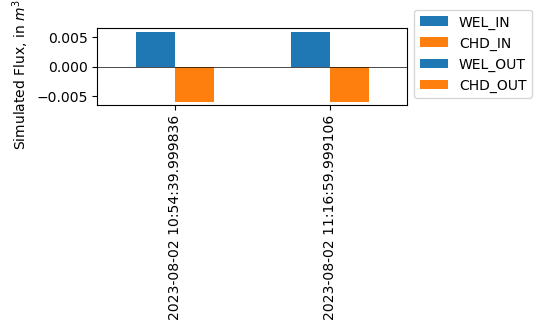

In [18]:
mfl = Mf6ListBudget(output_folder2 / 'flow.lst')             ; flux,_vol = mfl.get_dataframes(start_datetime='2023-08-02 10:52:00')   
flux,_vol.to_csv(output_folder / "a.csv")  ;  # flux.head()   # ax = flux['PERCENT_DISCREPANCY'].plot() ; ax.set_ylabel('Percent mass balance error')
fig, ax  = plt.subplots(figsize=(4, 1))
in_cols  = ['WEL_IN','CHD_IN']  ; out_cols = [c.replace('_IN', '_OUT') for c in in_cols]
flux[in_cols].plot.bar(stacked=False, ax=ax)        ;    (-flux[out_cols]).plot.bar(stacked=False, ax=ax)
ax.legend(loc='lower left', bbox_to_anchor=(1, 0)) ; ax.axhline(0, lw=0.5, c='k') ;   ax.set_ylabel('Simulated Flux, in $m^3/d$')

In [12]:
sim = flopy.mf6.MFSimulation.load(sim_ws = output_folder3 , exe_name=exe_name_mu , verbosity_level=0) ; mt = sim.get_model("trans")
gwt = sim.get_model('trans'); ucnobj = gwt.output.concentration() ; conc = ucnobj.get_alldata() ;  times = ucnobj.get_times()
print("OC package_trans  : ", mt.oc.output.methods()) ; print('conc', conc.shape) 

OC package_trans  :  ['list()', 'zonebudget()', 'budget()', 'budgetcsv()', 'concentration()']
conc (1500, 1, 1, 101)


heads (1, 1, 101)


Text(0, 0.5, 'Concentration')

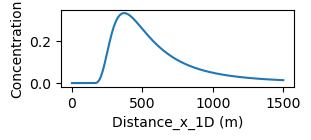

In [13]:
# "OBS" #
sim_ws = os.path.join (workspace, 'p02n2')    
fname = os.path.join  (sim_ws, 'mf6gwt', 'trans.obs.csv')   ; mf6gwt_ra = flopy.utils.Mf6Obs(fname).data
mf6conc = mf6gwt_ra["X008"] / source_concentration          ; then = pd.DataFrame(mf6conc)  ; then.to_csv(output_folder /"a_C.csv");   # OBS
fname  = os.path.join (sim_ws, 'mf6gwf','flow.hds')         ; hdobj  = flopy.utils.HeadFile (fname)  ; times = hdobj.get_times()    
heads  = hdobj.get_data()   ; heads2 = heads[0,:,:] ; then=pd.DataFrame(heads2);then.to_csv(output_folder/"b_H.csv") ; print('heads',heads.shape)
ttimes   =  pd.DataFrame(times);ttimes.to_csv(output_folder/"c_T.csv")
plt.figure(figsize=(3, 1))  ; plt.plot(mf6conc)   ; plt.xlabel('Distance_x_1D (m)')   ; plt.ylabel('Concentration') 

In [14]:
# https://flopy.readthedocs.io/en/3.3.4/_notebooks/tutorial01_mf6_output.html

In [15]:
tdis_ds = ((period1, int(period1 / delta_time), 1.0),(period2, int(period2 / delta_time), 1.0))
tdis_ds

((160, 160, 1.0), (1340, 1340, 1.0))

In [16]:
perlen=[(1),(1),(1340)] ; nstp=[1,6,40,1] ; tsmult=[1, 1.2, 1.2] ; tdis_ds=list(zip(perlen, nstp, tsmult)) ; tdis_ds[-2:]   # tdis_ds[:2]

[(1, 6, 1.2), (1340, 40, 1.2)]